In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_densenet121_unet(input_shape,num_classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.layers[0].output       ## 512
    s2 = densenet.get_layer("conv1/relu").output    ## 256
    s3 = densenet.get_layer("pool2_relu").output ## 128
    s4 = densenet.get_layer("pool3_relu").output  ## 64

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)             ## 64
    d2 = decoder_block(d1, s3, 256)             ## 128
    d3 = decoder_block(d2, s2, 128)             ## 256
    d4 = decoder_block(d3, s1, 64)              ## 512

    """ Outputs """
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs,name="DenseNet121")
    return model

In [ ]:
input_shape = (256, 256, 3)
model = build_densenet121_unet(input_shape,2)
model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

# Training

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/PFA' 

Mounted at /content/drive


In [ ]:
H = 256
W = 256

def create_dir(path):
    """Create a directory"""
    if not os.path.exists(path):
        os.mkdir(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path, split=0.2):

    images = sorted(glob(f"{path}/images/*.bmp"))
    masks = sorted(glob(f"{path}/GT_full/*.bmp"))
    
    print(len(masks), len(images))

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)
    print(len(train_x), len(train_y), len(valid_x), len(valid_y))
   
    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode('utf-8')
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x[x == 255] = 1
    x[x == 0] = 0 
    x[ x > 1] = 0
    x = x.astype(np.int32)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.int32])
    y = tf.one_hot(y, 2, dtype=tf.int32)
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 2])

    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)

    return dataset

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

"""Directory for storing files"""
create_dir("/content/drive/MyDrive/PFA/ROI_files_densenet121")

"""Hyperparameters"""
batch_size = 10
learning_rate = 1e-4
num_epochs = 30
model_path = os.path.join("/content/drive/MyDrive/PFA/ROI_files_densenet121", "model.h5")
csv_path = os.path.join("/content/drive/MyDrive/PFA/ROI_files_densenet121", "data.csv")

"""Dataset"""
dataset_path = os.path.join("/content/drive/MyDrive/PFA/new_data")
train_path = os.path.join(dataset_path, "train")

(train_x, train_y), (valid_x, valid_y) = load_data(train_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
test_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

"""Model"""

model = build_densenet121_unet((H, W, 3),2)
metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=metrics)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]
'''
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=test_dataset,
    validation_steps=valid_steps,
    callbacks=callbacks
)
'''

945 945
756 756 189 189
Train: 756 - 756
Valid: 189 - 189


'\nhistory = model.fit(\n    train_dataset,\n    steps_per_epoch=train_steps,\n    epochs=num_epochs,\n    validation_data=test_dataset,\n    validation_steps=valid_steps,\n    callbacks=callbacks\n)\n'

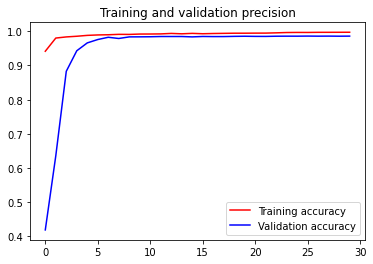

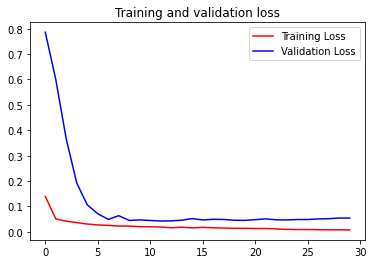

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def load_data(path):

    images = sorted(glob(f"{path}/images/*.bmp"))
    masks = sorted(glob(f"{path}/GT_full/*.bmp"))
    
    print(len(images), len(masks))
   
    return (images, masks)

In [ ]:
test_path = os.path.join(dataset_path, "test")
(test_x, test_y) = load_data(test_path)

48 48


In [ ]:
from tqdm import tqdm
num_classes = 2

In [ ]:
# Load the previously saved weights
model = tf.keras.models.load_model('/content/drive/MyDrive/PFA/ROI_files_densenet121/model.h5',custom_objects={'dice_coef': dice_coef,'iou':iou})

In [ ]:
res_path = os.path.join(dataset_path, "results_ROI_densenet121")
create_dir(res_path)
create_dir("/content/drive/MyDrive/PFA/single_roi_dense/")
res_path = "/content/drive/MyDrive/PFA/single_roi_dense/"
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ## Read image
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = x / 255.0
        x = x.astype(np.float32)

        ## Read mask
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y[y == 255] = 1
        y[y == 0] = 0 
        y[y > 1] = 0
        y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
        y = y * (255/num_classes)
        y = y.astype(np.int32)
        y = np.concatenate([y, y, y], axis=2)

        ## Prediction
        p = model.predict(np.expand_dims(x, axis=0))[0]
        p = np.argmax(p, axis=-1)
        p = np.expand_dims(p, axis=-1)
        p = p * (255/num_classes)
        p = p.astype(np.int32)
        p = np.concatenate([p, p, p], axis=2)

        x = x * 255.0
        x = x.astype(np.int32)

        h, w, _ = x.shape
        line = np.ones((h, 10, 3)) * 255

        print(x.shape, line.shape, y.shape, line.shape, p.shape)

        final_image = np.concatenate([x, line, y, line, p], axis=1)

        p[p != 0] = 255
        status = cv2.imwrite(f"{res_path}/{name}", p)
        print(status)

  2%|▏         | 1/48 [00:00<00:05,  8.76it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


  8%|▊         | 4/48 [00:00<00:04,  9.38it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 10%|█         | 5/48 [00:00<00:04,  9.57it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 17%|█▋        | 8/48 [00:00<00:04,  9.97it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 21%|██        | 10/48 [00:01<00:03, 10.15it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 27%|██▋       | 13/48 [00:01<00:03, 10.00it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3)

 29%|██▉       | 14/48 [00:01<00:03,  9.76it/s]

 (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 38%|███▊      | 18/48 [00:01<00:03,  9.80it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 42%|████▏     | 20/48 [00:02<00:02,  9.74it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3)

 46%|████▌     | 22/48 [00:02<00:02,  9.66it/s]

 (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 50%|█████     | 24/48 [00:02<00:02,  9.77it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 58%|█████▊    | 28/48 [00:02<00:02,  9.57it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 62%|██████▎   | 30/48 [00:03<00:01,  9.10it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 67%|██████▋   | 32/48 [00:03<00:01,  9.59it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 73%|███████▎  | 35/48 [00:03<00:01,  9.86it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 79%|███████▉  | 38/48 [00:03<00:00, 10.07it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 83%|████████▎ | 40/48 [00:04<00:00,  9.20it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 85%|████████▌ | 41/48 [00:04<00:00,  9.16it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 90%|████████▉ | 43/48 [00:04<00:00,  8.92it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 98%|█████████▊| 47/48 [00:04<00:00,  9.67it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


100%|██████████| 48/48 [00:04<00:00,  9.64it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
